In [1]:
import torch 
import json 
import numpy as np 
from sklearn.model_selection import train_test_split 
from torch.utils.data import SubsetRandomSampler, DataLoader,TensorDataset
from tqdm import tqdm 
import torch.nn.functional as F
from torch import nn


In [2]:
DATA_PATH = "./data/synthetic/train_data.json"
TEST_PATH = "./data/synthetic/test_data.json"
EPOCHS = 300
BATCH_SIZE = 150
SAVED_MODEL_PATH = "./models/model6.pth"

In [3]:
def load_dataset(data_path):
    with open(data_path,"r") as fp: 
        data = json.load(fp)
    X = np.array(data["data"])
    y = np.array(data["labels"])
    return X, y 

def to_device(data,device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device)for x in data]
    else:
        return data.to(device, non_blocking = True)
    
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl 
        self.device = device 
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)
    
    
X,y=load_dataset(DATA_PATH)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
dataset = TensorDataset(X,y)
X_test, y_test = load_dataset(TEST_PATH)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
testset = TensorDataset(X_test,y_test)

train_dl = DataLoader(dataset, BATCH_SIZE, shuffle = True, drop_last=True)
test_dl = DataLoader(testset, BATCH_SIZE, shuffle = True, drop_last=True)

input_shape = dataset[0][0].shape
device = torch.device('cuda')
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [4]:
print(testset[0][0].shape)
print(type(dataset[0][0]))

torch.Size([1, 128, 16])
<class 'torch.Tensor'>


In [9]:
latent_size = 11
# https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,stride = 2, padding=1 , kernel_size=3)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(32,64, stride = 2, padding =1, kernel_size=3)
        self.conv3 = nn.Conv2d(64,128,stride =2, padding =1, kernel_size = 3)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4096,latent_size)
        self.fc = nn.Linear(latent_size,4096)
        self.deconv3 = nn.ConvTranspose2d(128,64,stride =2, kernel_size = 3, padding =1,output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64,32,stride =2, kernel_size = 3,padding =1,output_padding=1)
        self.deconv1 = nn.ConvTranspose2d(32,1,stride =2, kernel_size = 3,padding =1,output_padding=1)
    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.conv3(out)        
        out = self.relu(out)
        out = self.flatten(out)
        out = self.linear(out)
        out = self.relu(out)
        out = self.fc(out)
        out = self.relu(out)
        out = out.reshape(-1,128,16,2)
        out = self.deconv3(out)
        out = self.relu(out)
        out = self.deconv2(out)
        out = self.relu(out)
        out = self.deconv1(out)
        return out
autoencoder = Autoencoder()
autoencoder.to(device)
autoencoder.load_state_dict(torch.load(SAVED_MODEL_PATH))

<All keys matched successfully>

In [10]:
from torchsummary import summary 
summary(autoencoder, input_size = (1,128,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 32, 64, 8]             320
         LeakyReLU-2            [-1, 32, 64, 8]               0
            Conv2d-3            [-1, 64, 32, 4]          18,496
         LeakyReLU-4            [-1, 64, 32, 4]               0
            Conv2d-5           [-1, 128, 16, 2]          73,856
         LeakyReLU-6           [-1, 128, 16, 2]               0
           Flatten-7                 [-1, 4096]               0
            Linear-8                   [-1, 11]          45,067
         LeakyReLU-9                   [-1, 11]               0
           Linear-10                 [-1, 4096]          49,152
        LeakyReLU-11                 [-1, 4096]               0
  ConvTranspose2d-12            [-1, 64, 32, 4]          73,792
        LeakyReLU-13            [-1, 64, 32, 4]               0
  ConvTranspose2d-14            [-1, 32

spectrogram shape:  torch.Size([150, 1, 128, 16])
output shape:  torch.Size([150, 1, 128, 16])
torch.Size([128, 16])


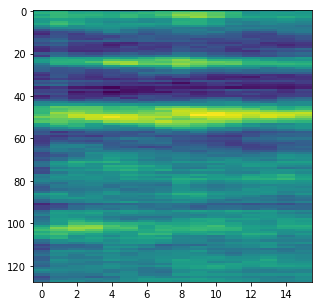

In [11]:

for images, labels in test_dl: 
    print("spectrogram shape: ", images.shape)
    out = autoencoder(images)
    
    print("output shape: ", out.shape)
    break 
    
img = out[0][0].detach().cpu()
print(img.shape)
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(1,1,figsize = (5,5))
ax.imshow(img, aspect = 'auto')


## Now start training and see what the resulting image would look like 


In [18]:
criterion = nn.MSELoss()
ae_opt= torch.optim.Adam(autoencoder.parameters(), lr = 0.0002)


In [19]:
loss_list = []
EPOCHS = 5000
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_dl):
        reconstructed = autoencoder(images)
        loss = criterion(images, reconstructed)
        
        ae_opt.zero_grad()
        loss.backward()
        ae_opt.step()
    
    loss_list.append(np.sum(loss.item()))
    
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, EPOCHS, loss.item()))

        


epoch [1/5000], loss:128.3113
epoch [2/5000], loss:131.5088
epoch [3/5000], loss:120.0177
epoch [4/5000], loss:82.3757
epoch [5/5000], loss:74.1973
epoch [6/5000], loss:67.6234
epoch [7/5000], loss:63.1997
epoch [8/5000], loss:62.1836
epoch [9/5000], loss:59.8298
epoch [10/5000], loss:58.2239
epoch [11/5000], loss:60.7482
epoch [12/5000], loss:51.8311
epoch [13/5000], loss:53.7608
epoch [14/5000], loss:53.6467
epoch [15/5000], loss:56.0074
epoch [16/5000], loss:51.4842
epoch [17/5000], loss:54.4885
epoch [18/5000], loss:55.2196
epoch [19/5000], loss:53.5934
epoch [20/5000], loss:51.0330
epoch [21/5000], loss:51.0259
epoch [22/5000], loss:54.0603
epoch [23/5000], loss:61.1348
epoch [24/5000], loss:56.1862
epoch [25/5000], loss:59.5575
epoch [26/5000], loss:53.8143
epoch [27/5000], loss:54.3169
epoch [28/5000], loss:56.7817
epoch [29/5000], loss:59.3753
epoch [30/5000], loss:54.3886
epoch [31/5000], loss:50.8005
epoch [32/5000], loss:50.8601
epoch [33/5000], loss:51.6123
epoch [34/5000],

epoch [269/5000], loss:30.1758
epoch [270/5000], loss:29.8260
epoch [271/5000], loss:30.0326
epoch [272/5000], loss:29.8092
epoch [273/5000], loss:29.7112
epoch [274/5000], loss:29.9441
epoch [275/5000], loss:29.9695
epoch [276/5000], loss:29.8862
epoch [277/5000], loss:29.9778
epoch [278/5000], loss:29.7457
epoch [279/5000], loss:29.8476
epoch [280/5000], loss:29.7336
epoch [281/5000], loss:29.7843
epoch [282/5000], loss:29.9767
epoch [283/5000], loss:29.8086
epoch [284/5000], loss:30.0603
epoch [285/5000], loss:29.7075
epoch [286/5000], loss:29.4375
epoch [287/5000], loss:29.8781
epoch [288/5000], loss:29.6496
epoch [289/5000], loss:29.8790
epoch [290/5000], loss:29.6780
epoch [291/5000], loss:29.8054
epoch [292/5000], loss:29.6834
epoch [293/5000], loss:29.5698
epoch [294/5000], loss:29.4000
epoch [295/5000], loss:29.7684
epoch [296/5000], loss:29.9977
epoch [297/5000], loss:29.5901
epoch [298/5000], loss:29.6108
epoch [299/5000], loss:29.8949
epoch [300/5000], loss:29.4558
epoch [3

epoch [534/5000], loss:29.1560
epoch [535/5000], loss:29.0037
epoch [536/5000], loss:29.1390
epoch [537/5000], loss:28.4822
epoch [538/5000], loss:28.7205
epoch [539/5000], loss:28.8644
epoch [540/5000], loss:29.1435
epoch [541/5000], loss:29.1331
epoch [542/5000], loss:28.8292
epoch [543/5000], loss:28.7802
epoch [544/5000], loss:29.1534
epoch [545/5000], loss:28.5973
epoch [546/5000], loss:28.6790
epoch [547/5000], loss:28.8867
epoch [548/5000], loss:28.8289
epoch [549/5000], loss:29.6098
epoch [550/5000], loss:28.7717
epoch [551/5000], loss:28.6097
epoch [552/5000], loss:28.8340
epoch [553/5000], loss:28.7173
epoch [554/5000], loss:28.5790
epoch [555/5000], loss:28.7567
epoch [556/5000], loss:29.1933
epoch [557/5000], loss:29.0534
epoch [558/5000], loss:28.9016
epoch [559/5000], loss:28.8362
epoch [560/5000], loss:29.0339
epoch [561/5000], loss:28.8756
epoch [562/5000], loss:28.9883
epoch [563/5000], loss:28.7855
epoch [564/5000], loss:28.5333
epoch [565/5000], loss:28.8800
epoch [5

epoch [799/5000], loss:28.1038
epoch [800/5000], loss:27.8669
epoch [801/5000], loss:28.4255
epoch [802/5000], loss:28.5467
epoch [803/5000], loss:28.9194
epoch [804/5000], loss:28.7552
epoch [805/5000], loss:28.4334
epoch [806/5000], loss:28.5401
epoch [807/5000], loss:28.1687
epoch [808/5000], loss:28.2671
epoch [809/5000], loss:28.2649
epoch [810/5000], loss:28.3177
epoch [811/5000], loss:28.4726
epoch [812/5000], loss:28.0098
epoch [813/5000], loss:28.4781
epoch [814/5000], loss:28.1626
epoch [815/5000], loss:28.4186
epoch [816/5000], loss:28.3966
epoch [817/5000], loss:27.7686
epoch [818/5000], loss:28.1562
epoch [819/5000], loss:28.2067
epoch [820/5000], loss:28.6534
epoch [821/5000], loss:28.5010
epoch [822/5000], loss:27.9849
epoch [823/5000], loss:28.5627
epoch [824/5000], loss:28.5420
epoch [825/5000], loss:28.1466
epoch [826/5000], loss:28.1821
epoch [827/5000], loss:28.1309
epoch [828/5000], loss:28.4095
epoch [829/5000], loss:27.9737
epoch [830/5000], loss:27.8867
epoch [8

epoch [1062/5000], loss:27.9669
epoch [1063/5000], loss:27.6826
epoch [1064/5000], loss:28.0549
epoch [1065/5000], loss:27.6963
epoch [1066/5000], loss:27.5576
epoch [1067/5000], loss:27.9877
epoch [1068/5000], loss:27.6815
epoch [1069/5000], loss:27.8178
epoch [1070/5000], loss:27.6729
epoch [1071/5000], loss:27.9299
epoch [1072/5000], loss:27.5736
epoch [1073/5000], loss:27.6220
epoch [1074/5000], loss:27.8919
epoch [1075/5000], loss:27.8103
epoch [1076/5000], loss:28.0104
epoch [1077/5000], loss:27.6245
epoch [1078/5000], loss:27.5210
epoch [1079/5000], loss:27.6818
epoch [1080/5000], loss:28.1647
epoch [1081/5000], loss:27.5948
epoch [1082/5000], loss:27.6469
epoch [1083/5000], loss:27.7280
epoch [1084/5000], loss:27.7128
epoch [1085/5000], loss:27.8045
epoch [1086/5000], loss:28.1180
epoch [1087/5000], loss:27.8136
epoch [1088/5000], loss:27.8237
epoch [1089/5000], loss:28.0401
epoch [1090/5000], loss:27.8193
epoch [1091/5000], loss:28.0191
epoch [1092/5000], loss:28.0785
epoch [1

epoch [1319/5000], loss:27.4775
epoch [1320/5000], loss:27.3581
epoch [1321/5000], loss:27.2973
epoch [1322/5000], loss:27.6723
epoch [1323/5000], loss:26.8009
epoch [1324/5000], loss:27.5539
epoch [1325/5000], loss:27.6066
epoch [1326/5000], loss:27.4923
epoch [1327/5000], loss:27.2687
epoch [1328/5000], loss:27.2978
epoch [1329/5000], loss:27.3197
epoch [1330/5000], loss:27.5826
epoch [1331/5000], loss:27.4255
epoch [1332/5000], loss:27.3788
epoch [1333/5000], loss:27.4052
epoch [1334/5000], loss:27.5374
epoch [1335/5000], loss:27.5842
epoch [1336/5000], loss:27.7854
epoch [1337/5000], loss:27.1437
epoch [1338/5000], loss:27.3336
epoch [1339/5000], loss:27.3162
epoch [1340/5000], loss:27.2665
epoch [1341/5000], loss:27.0266
epoch [1342/5000], loss:27.4299
epoch [1343/5000], loss:27.0701
epoch [1344/5000], loss:27.0678
epoch [1345/5000], loss:27.4246
epoch [1346/5000], loss:27.7023
epoch [1347/5000], loss:27.4831
epoch [1348/5000], loss:27.3566
epoch [1349/5000], loss:27.6667
epoch [1

epoch [1576/5000], loss:26.8162
epoch [1577/5000], loss:27.0942
epoch [1578/5000], loss:27.2804
epoch [1579/5000], loss:26.9317
epoch [1580/5000], loss:26.9278
epoch [1581/5000], loss:27.0457
epoch [1582/5000], loss:27.4959
epoch [1583/5000], loss:26.9555
epoch [1584/5000], loss:27.5996
epoch [1585/5000], loss:27.1563
epoch [1586/5000], loss:27.0711
epoch [1587/5000], loss:27.3198
epoch [1588/5000], loss:27.0483
epoch [1589/5000], loss:27.1622
epoch [1590/5000], loss:27.2765
epoch [1591/5000], loss:27.0610
epoch [1592/5000], loss:27.1807
epoch [1593/5000], loss:26.9611
epoch [1594/5000], loss:27.1611
epoch [1595/5000], loss:26.9588
epoch [1596/5000], loss:27.2222
epoch [1597/5000], loss:27.2477
epoch [1598/5000], loss:27.4241
epoch [1599/5000], loss:27.4156
epoch [1600/5000], loss:27.2180
epoch [1601/5000], loss:27.2173
epoch [1602/5000], loss:27.3080
epoch [1603/5000], loss:27.5227
epoch [1604/5000], loss:27.3536
epoch [1605/5000], loss:27.3157
epoch [1606/5000], loss:27.2688
epoch [1

epoch [1833/5000], loss:26.5929
epoch [1834/5000], loss:27.1647
epoch [1835/5000], loss:27.1014
epoch [1836/5000], loss:27.0220
epoch [1837/5000], loss:26.7557
epoch [1838/5000], loss:27.0345
epoch [1839/5000], loss:27.3246
epoch [1840/5000], loss:26.8694
epoch [1841/5000], loss:26.9625
epoch [1842/5000], loss:27.4099
epoch [1843/5000], loss:26.5293
epoch [1844/5000], loss:26.4779
epoch [1845/5000], loss:27.3329
epoch [1846/5000], loss:26.5948
epoch [1847/5000], loss:27.0294
epoch [1848/5000], loss:26.8550
epoch [1849/5000], loss:27.1494
epoch [1850/5000], loss:26.8620
epoch [1851/5000], loss:26.9148
epoch [1852/5000], loss:26.9700
epoch [1853/5000], loss:26.9421
epoch [1854/5000], loss:26.8317
epoch [1855/5000], loss:27.0644
epoch [1856/5000], loss:26.8781
epoch [1857/5000], loss:27.0296
epoch [1858/5000], loss:26.8987
epoch [1859/5000], loss:27.1045
epoch [1860/5000], loss:27.0238
epoch [1861/5000], loss:26.9541
epoch [1862/5000], loss:27.0587
epoch [1863/5000], loss:26.5492
epoch [1

epoch [2090/5000], loss:26.3094
epoch [2091/5000], loss:26.4927
epoch [2092/5000], loss:26.9357
epoch [2093/5000], loss:26.6260
epoch [2094/5000], loss:26.7376
epoch [2095/5000], loss:26.7759
epoch [2096/5000], loss:26.5923
epoch [2097/5000], loss:26.3981
epoch [2098/5000], loss:26.7130
epoch [2099/5000], loss:26.5619
epoch [2100/5000], loss:26.8817
epoch [2101/5000], loss:26.5211
epoch [2102/5000], loss:26.7390
epoch [2103/5000], loss:26.7709
epoch [2104/5000], loss:26.5679
epoch [2105/5000], loss:26.5301
epoch [2106/5000], loss:26.5926
epoch [2107/5000], loss:26.1895
epoch [2108/5000], loss:26.6833
epoch [2109/5000], loss:26.3603
epoch [2110/5000], loss:26.5381
epoch [2111/5000], loss:26.5445
epoch [2112/5000], loss:26.5574
epoch [2113/5000], loss:26.4644
epoch [2114/5000], loss:26.4200
epoch [2115/5000], loss:26.6683
epoch [2116/5000], loss:26.9102
epoch [2117/5000], loss:26.4490
epoch [2118/5000], loss:26.9223
epoch [2119/5000], loss:26.2979
epoch [2120/5000], loss:26.8094
epoch [2

epoch [2347/5000], loss:26.2562
epoch [2348/5000], loss:25.9507
epoch [2349/5000], loss:26.1483
epoch [2350/5000], loss:26.4260
epoch [2351/5000], loss:26.5155
epoch [2352/5000], loss:26.2564
epoch [2353/5000], loss:26.0519
epoch [2354/5000], loss:26.9700
epoch [2355/5000], loss:26.6583
epoch [2356/5000], loss:26.5910
epoch [2357/5000], loss:26.2751
epoch [2358/5000], loss:26.6754
epoch [2359/5000], loss:26.3372
epoch [2360/5000], loss:26.4302
epoch [2361/5000], loss:26.0832
epoch [2362/5000], loss:26.6821
epoch [2363/5000], loss:26.0821
epoch [2364/5000], loss:26.6575
epoch [2365/5000], loss:26.3805
epoch [2366/5000], loss:26.4318
epoch [2367/5000], loss:26.3309
epoch [2368/5000], loss:26.2731
epoch [2369/5000], loss:26.2358
epoch [2370/5000], loss:26.6274
epoch [2371/5000], loss:26.7674
epoch [2372/5000], loss:26.6142
epoch [2373/5000], loss:26.2384
epoch [2374/5000], loss:26.9013
epoch [2375/5000], loss:26.4515
epoch [2376/5000], loss:26.2007
epoch [2377/5000], loss:26.1154
epoch [2

epoch [2604/5000], loss:26.3566
epoch [2605/5000], loss:26.2585
epoch [2606/5000], loss:26.4944
epoch [2607/5000], loss:26.1162
epoch [2608/5000], loss:26.3056
epoch [2609/5000], loss:26.1347
epoch [2610/5000], loss:26.1088
epoch [2611/5000], loss:26.0725
epoch [2612/5000], loss:26.2325
epoch [2613/5000], loss:26.9088
epoch [2614/5000], loss:26.2729
epoch [2615/5000], loss:26.3572
epoch [2616/5000], loss:26.1899
epoch [2617/5000], loss:26.2570
epoch [2618/5000], loss:26.1369
epoch [2619/5000], loss:26.4871
epoch [2620/5000], loss:26.1366
epoch [2621/5000], loss:26.2641
epoch [2622/5000], loss:25.8493
epoch [2623/5000], loss:26.5925
epoch [2624/5000], loss:26.1969
epoch [2625/5000], loss:26.2838
epoch [2626/5000], loss:26.1907
epoch [2627/5000], loss:26.1263
epoch [2628/5000], loss:26.2047
epoch [2629/5000], loss:25.8868
epoch [2630/5000], loss:26.0169
epoch [2631/5000], loss:26.3227
epoch [2632/5000], loss:26.4921
epoch [2633/5000], loss:26.6055
epoch [2634/5000], loss:26.2614
epoch [2

epoch [2861/5000], loss:26.2599
epoch [2862/5000], loss:26.1495
epoch [2863/5000], loss:26.1455
epoch [2864/5000], loss:26.0965
epoch [2865/5000], loss:26.2855
epoch [2866/5000], loss:26.0620
epoch [2867/5000], loss:26.0502
epoch [2868/5000], loss:26.1803
epoch [2869/5000], loss:25.8456
epoch [2870/5000], loss:25.9932
epoch [2871/5000], loss:26.0977
epoch [2872/5000], loss:25.5663
epoch [2873/5000], loss:26.3760
epoch [2874/5000], loss:26.4689
epoch [2875/5000], loss:26.5017
epoch [2876/5000], loss:26.1594
epoch [2877/5000], loss:26.0816
epoch [2878/5000], loss:26.3509
epoch [2879/5000], loss:25.9315
epoch [2880/5000], loss:26.1277
epoch [2881/5000], loss:25.9270
epoch [2882/5000], loss:26.1651
epoch [2883/5000], loss:26.2923
epoch [2884/5000], loss:25.8889
epoch [2885/5000], loss:25.8371
epoch [2886/5000], loss:26.4300
epoch [2887/5000], loss:26.3677
epoch [2888/5000], loss:25.9229
epoch [2889/5000], loss:26.0711
epoch [2890/5000], loss:26.5155
epoch [2891/5000], loss:26.0288
epoch [2

epoch [3118/5000], loss:25.7389
epoch [3119/5000], loss:26.0945
epoch [3120/5000], loss:25.7734
epoch [3121/5000], loss:25.6718
epoch [3122/5000], loss:25.8277
epoch [3123/5000], loss:25.7089
epoch [3124/5000], loss:25.5867
epoch [3125/5000], loss:25.8295
epoch [3126/5000], loss:26.2338
epoch [3127/5000], loss:25.6765
epoch [3128/5000], loss:27.7127
epoch [3129/5000], loss:27.8022
epoch [3130/5000], loss:25.8855
epoch [3131/5000], loss:26.1408
epoch [3132/5000], loss:26.3168
epoch [3133/5000], loss:26.0797
epoch [3134/5000], loss:26.2135
epoch [3135/5000], loss:25.9843
epoch [3136/5000], loss:26.2115
epoch [3137/5000], loss:26.3327
epoch [3138/5000], loss:26.0691
epoch [3139/5000], loss:25.9452
epoch [3140/5000], loss:26.2242
epoch [3141/5000], loss:25.7960
epoch [3142/5000], loss:25.7496
epoch [3143/5000], loss:25.8192
epoch [3144/5000], loss:26.0989
epoch [3145/5000], loss:25.7734
epoch [3146/5000], loss:25.8229
epoch [3147/5000], loss:25.4975
epoch [3148/5000], loss:25.7148
epoch [3

epoch [3375/5000], loss:25.5264
epoch [3376/5000], loss:25.7008
epoch [3377/5000], loss:26.5053
epoch [3378/5000], loss:25.7964
epoch [3379/5000], loss:25.6121
epoch [3380/5000], loss:25.5779
epoch [3381/5000], loss:25.6763
epoch [3382/5000], loss:26.0106
epoch [3383/5000], loss:25.5930
epoch [3384/5000], loss:26.2552
epoch [3385/5000], loss:25.5965
epoch [3386/5000], loss:25.8206
epoch [3387/5000], loss:25.5678
epoch [3388/5000], loss:25.9508
epoch [3389/5000], loss:25.9133
epoch [3390/5000], loss:26.0010
epoch [3391/5000], loss:25.6344
epoch [3392/5000], loss:26.0778
epoch [3393/5000], loss:25.7464
epoch [3394/5000], loss:25.8759
epoch [3395/5000], loss:25.9708
epoch [3396/5000], loss:25.7001
epoch [3397/5000], loss:25.6413
epoch [3398/5000], loss:26.0181
epoch [3399/5000], loss:25.7152
epoch [3400/5000], loss:25.7342
epoch [3401/5000], loss:25.9384
epoch [3402/5000], loss:25.6857
epoch [3403/5000], loss:26.1508
epoch [3404/5000], loss:26.1595
epoch [3405/5000], loss:25.2831
epoch [3

epoch [3632/5000], loss:26.2464
epoch [3633/5000], loss:26.2573
epoch [3634/5000], loss:25.5785
epoch [3635/5000], loss:26.0016
epoch [3636/5000], loss:25.5844
epoch [3637/5000], loss:25.8959
epoch [3638/5000], loss:25.6312
epoch [3639/5000], loss:25.5275
epoch [3640/5000], loss:25.5321
epoch [3641/5000], loss:26.0047
epoch [3642/5000], loss:25.6658
epoch [3643/5000], loss:25.4955
epoch [3644/5000], loss:26.3329
epoch [3645/5000], loss:25.8282
epoch [3646/5000], loss:25.7507
epoch [3647/5000], loss:25.6793
epoch [3648/5000], loss:25.7002
epoch [3649/5000], loss:26.0464
epoch [3650/5000], loss:25.2484
epoch [3651/5000], loss:25.8423
epoch [3652/5000], loss:25.5221
epoch [3653/5000], loss:25.3265
epoch [3654/5000], loss:25.2733
epoch [3655/5000], loss:25.9730
epoch [3656/5000], loss:26.2929
epoch [3657/5000], loss:25.8517
epoch [3658/5000], loss:25.6380
epoch [3659/5000], loss:25.2201
epoch [3660/5000], loss:25.6367
epoch [3661/5000], loss:25.7408
epoch [3662/5000], loss:25.5176
epoch [3

epoch [3889/5000], loss:25.4381
epoch [3890/5000], loss:25.8721
epoch [3891/5000], loss:25.7235
epoch [3892/5000], loss:25.6548
epoch [3893/5000], loss:25.7479
epoch [3894/5000], loss:25.2154
epoch [3895/5000], loss:26.0050
epoch [3896/5000], loss:25.5473
epoch [3897/5000], loss:25.9352
epoch [3898/5000], loss:25.5341
epoch [3899/5000], loss:25.3334
epoch [3900/5000], loss:25.5315
epoch [3901/5000], loss:25.2556
epoch [3902/5000], loss:25.4334
epoch [3903/5000], loss:25.5201
epoch [3904/5000], loss:25.3165
epoch [3905/5000], loss:25.7643
epoch [3906/5000], loss:25.2981
epoch [3907/5000], loss:25.4436
epoch [3908/5000], loss:25.7621
epoch [3909/5000], loss:25.2300
epoch [3910/5000], loss:25.9130
epoch [3911/5000], loss:25.7696
epoch [3912/5000], loss:25.1707
epoch [3913/5000], loss:26.0257
epoch [3914/5000], loss:26.1513
epoch [3915/5000], loss:26.3123
epoch [3916/5000], loss:25.4037
epoch [3917/5000], loss:25.4755
epoch [3918/5000], loss:25.7144
epoch [3919/5000], loss:25.3533
epoch [3

epoch [4146/5000], loss:25.3363
epoch [4147/5000], loss:25.1377
epoch [4148/5000], loss:25.4456
epoch [4149/5000], loss:25.5092
epoch [4150/5000], loss:26.8101
epoch [4151/5000], loss:25.8327
epoch [4152/5000], loss:26.7308
epoch [4153/5000], loss:26.3013
epoch [4154/5000], loss:25.2982
epoch [4155/5000], loss:25.9224
epoch [4156/5000], loss:25.6517
epoch [4157/5000], loss:24.8947
epoch [4158/5000], loss:24.7300
epoch [4159/5000], loss:25.6694
epoch [4160/5000], loss:25.1697
epoch [4161/5000], loss:25.5663
epoch [4162/5000], loss:25.1179
epoch [4163/5000], loss:25.5158
epoch [4164/5000], loss:25.6600
epoch [4165/5000], loss:25.3846
epoch [4166/5000], loss:25.4952
epoch [4167/5000], loss:25.4388
epoch [4168/5000], loss:25.3571
epoch [4169/5000], loss:25.0530
epoch [4170/5000], loss:25.1781
epoch [4171/5000], loss:25.2768
epoch [4172/5000], loss:25.3483
epoch [4173/5000], loss:26.0075
epoch [4174/5000], loss:25.8758
epoch [4175/5000], loss:25.6082
epoch [4176/5000], loss:25.6262
epoch [4

epoch [4403/5000], loss:25.9898
epoch [4404/5000], loss:25.2571
epoch [4405/5000], loss:25.3373
epoch [4406/5000], loss:25.2113
epoch [4407/5000], loss:25.6886
epoch [4408/5000], loss:25.3965
epoch [4409/5000], loss:25.1603
epoch [4410/5000], loss:25.5664
epoch [4411/5000], loss:25.4782
epoch [4412/5000], loss:25.6629
epoch [4413/5000], loss:25.2489
epoch [4414/5000], loss:25.6160
epoch [4415/5000], loss:25.8819
epoch [4416/5000], loss:25.4420
epoch [4417/5000], loss:25.9318
epoch [4418/5000], loss:25.7739
epoch [4419/5000], loss:25.5059
epoch [4420/5000], loss:25.3034
epoch [4421/5000], loss:25.1435
epoch [4422/5000], loss:25.4722
epoch [4423/5000], loss:24.8516
epoch [4424/5000], loss:25.1407
epoch [4425/5000], loss:25.1501
epoch [4426/5000], loss:25.1278
epoch [4427/5000], loss:25.5125
epoch [4428/5000], loss:25.0279
epoch [4429/5000], loss:26.1591
epoch [4430/5000], loss:25.5521
epoch [4431/5000], loss:25.2788
epoch [4432/5000], loss:25.2207
epoch [4433/5000], loss:25.5496
epoch [4

epoch [4660/5000], loss:25.3338
epoch [4661/5000], loss:25.2405
epoch [4662/5000], loss:24.8542
epoch [4663/5000], loss:25.2946
epoch [4664/5000], loss:25.4005
epoch [4665/5000], loss:25.1536
epoch [4666/5000], loss:25.5990
epoch [4667/5000], loss:25.5987
epoch [4668/5000], loss:25.1340
epoch [4669/5000], loss:25.1659
epoch [4670/5000], loss:25.4066
epoch [4671/5000], loss:25.5668
epoch [4672/5000], loss:24.9672
epoch [4673/5000], loss:24.8215
epoch [4674/5000], loss:25.6993
epoch [4675/5000], loss:26.5856
epoch [4676/5000], loss:25.3044
epoch [4677/5000], loss:25.3365
epoch [4678/5000], loss:25.4156
epoch [4679/5000], loss:25.1945
epoch [4680/5000], loss:25.0907
epoch [4681/5000], loss:25.1535
epoch [4682/5000], loss:25.3278
epoch [4683/5000], loss:25.0645
epoch [4684/5000], loss:25.2553
epoch [4685/5000], loss:24.6804
epoch [4686/5000], loss:25.0182
epoch [4687/5000], loss:25.2354
epoch [4688/5000], loss:25.4084
epoch [4689/5000], loss:24.7815
epoch [4690/5000], loss:25.0201
epoch [4

epoch [4917/5000], loss:25.2842
epoch [4918/5000], loss:25.7807
epoch [4919/5000], loss:25.3455
epoch [4920/5000], loss:25.2562
epoch [4921/5000], loss:25.1293
epoch [4922/5000], loss:25.2418
epoch [4923/5000], loss:25.0955
epoch [4924/5000], loss:25.1057
epoch [4925/5000], loss:25.1930
epoch [4926/5000], loss:25.2537
epoch [4927/5000], loss:25.4097
epoch [4928/5000], loss:25.0586
epoch [4929/5000], loss:24.9563
epoch [4930/5000], loss:25.5554
epoch [4931/5000], loss:24.8802
epoch [4932/5000], loss:24.8589
epoch [4933/5000], loss:25.4266
epoch [4934/5000], loss:27.1041
epoch [4935/5000], loss:26.2889
epoch [4936/5000], loss:25.3171
epoch [4937/5000], loss:24.6407
epoch [4938/5000], loss:25.1978
epoch [4939/5000], loss:25.0741
epoch [4940/5000], loss:25.2249
epoch [4941/5000], loss:25.3657
epoch [4942/5000], loss:24.7759
epoch [4943/5000], loss:24.7944
epoch [4944/5000], loss:25.1302
epoch [4945/5000], loss:24.8875
epoch [4946/5000], loss:24.8771
epoch [4947/5000], loss:25.1088
epoch [4

In [20]:
torch.save(autoencoder.state_dict(), SAVED_MODEL_PATH)

spectrogram shape:  torch.Size([150, 1, 128, 16])
output shape:  torch.Size([150, 1, 128, 16])
torch.Size([128, 16])
26.01825 -2.1273837
14.152781 -65.84722


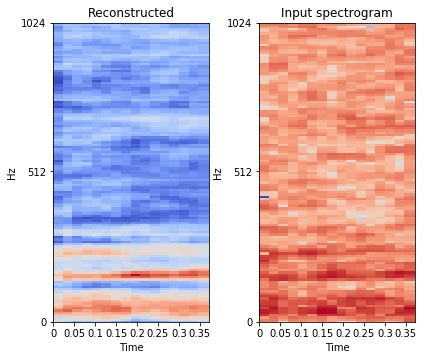

In [61]:
import librosa 
import matplotlib.pyplot as plt
import librosa.display 

for images, labels in train_dl: 
    print("spectrogram shape: ", images.shape)
    out = autoencoder(images)
    print("output shape: ", out.shape)
    break 
    
img = out[1][0].detach().cpu()
print(img.shape) 
import matplotlib.pyplot as plt 
fig, axs = plt.subplots(1,2,figsize = (6,5))
fig.tight_layout(pad=2.0)

img = img.numpy()
xt  = librosa.power_to_db(img)
librosa.display.specshow(img, y_axis = "mel",x_axis = "time", fmax = 1024, ax = axs[0])
print(np.max(img),np.min(img))
print(np.max(xt), np.min(xt))
xt1 = images[1][0].detach().cpu().numpy()
axs[0].set_title("Reconstructed")
axs[1].set_title("Input spectrogram")

librosa.display.specshow(xt1, y_axis = "mel",x_axis= "time", fmax = 1024, ax = axs[1])


In [54]:
out_list = [[] for i in range(3)]
imgs = [[] for i in range(3)]
mse_per_image = nn.MSELoss(reduction='none')
for images, labels in test_dl:
    print(images.shape)
    out = autoencoder(images)
    losses = torch.sum(mse_per_image(images, out).detach().cpu(), dim =(1,2,3))/(images.shape[-1]*images.shape[-2])
    losses = losses.numpy()
    for i in range(len(images)):
        out_list[int(labels[i].detach().cpu())].append(losses[i])
        imgs[int(labels[i].detach().cpu())].append(images[i])


torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])


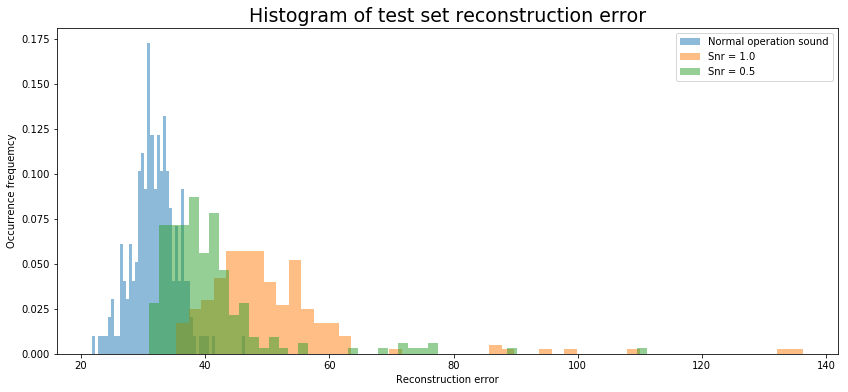

torch.Size([1, 128, 16])


In [23]:

fig, ax = plt.subplots(1,1,figsize = (14,6))

ax.title.set_text("Histogram of test set reconstruction error")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Snr = 1.0", "Snr = 0.5"]

for i in range(len(out_list)):
    ax.hist(bins = 50, x=out_list[i], alpha = 0.5, label = labels[i], density = True)

ax.set_xlabel("Reconstruction error")
ax.set_ylabel("Occurrence frequemcy")
ax.legend()
plt.show()

min_img = imgs[1][out_list[1].index(min(out_list[1]))]
print(np.shape(min_img))


torch.Size([1, 128, 16])
torch.Size([128, 16])


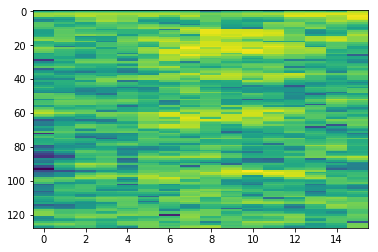

In [24]:
min_img = imgs[1][out_list[1].index(min(out_list[1]))]
print(np.shape(min_img))
im = min_img.detach().cpu().squeeze()
print(np.shape(im))
plt.imshow(im, aspect = "auto")

The difference is 0.10347226358230183


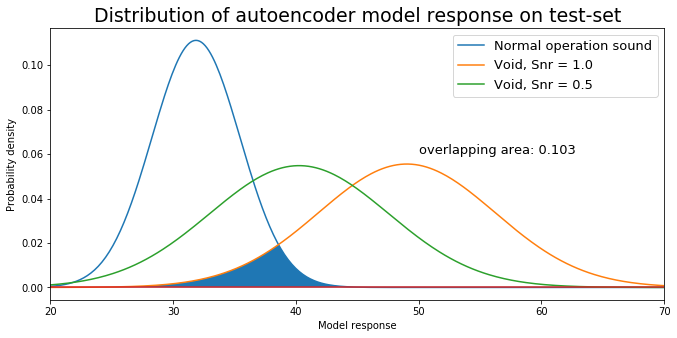

In [25]:
import scipy.integrate
from scipy.stats import norm
fig, ax = plt.subplots(1,1,figsize = (11,5))
integrate = scipy.integrate.quad
ax.title.set_text("Distribution of autoencoder model response on test-set")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Void, Snr = 1.0", "Void, Snr = 0.5"]
x = np.linspace(20,140,800)
SMALL_SIZE = 13
MEDIUM_SIZE = 13
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
 
for i in range(len(out_list)):
    truncated = [out_list[i][j] if out_list[i][j]<=65 else 65 for j in range(len(out_list[i]))]
    if i ==1: 
        m_old = m
        s_old = s
        y_old = y
    m = np.mean(truncated)
    s = np.sqrt(np.var(truncated))
    y = norm.pdf(x,m,s)

    if i==1:
        under_fun = lambda x: min(norm.pdf(x,m,s), norm.pdf(x,m_old, s_old))
        diff = integrate(under_fun, 10,60)
        print(f"The difference is {diff[0]}")
        y_min = [min(y[i],y_old[i]) for i in range(len(y))]
        ax.fill_between(x, y_min)
    ax.plot(x,y, label = labels[i])
    


ax.plot(x, [0 for i in range(len(x))])
ax.set_xlim([20,70])
ax.set_xlabel("Model response")
ax.set_ylabel("Probability density")
ax.text(50,0.06,f"overlapping area: {diff[0]:.3f}")
ax.legend()
plt.show()


The aoc score is 0.993 for snr =1
The aoc score is 0.904 for snr =0.5


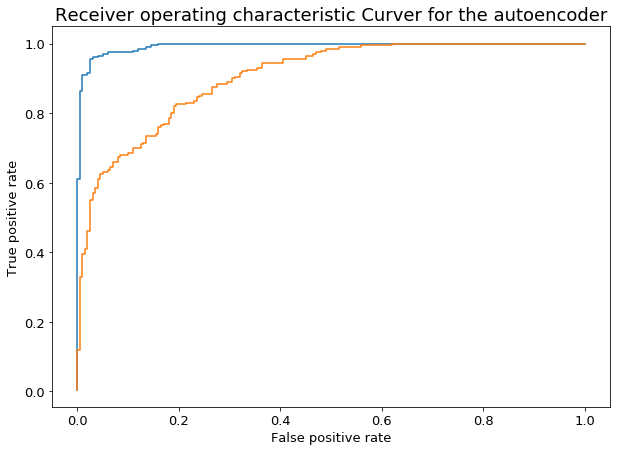

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pickle 
scores1 = out_list[0]+out_list[1]
y1 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[1]))]
fpr1, tpr1, thresholds1 = roc_curve(y1, scores1, pos_label = 1)

aoc_snr1 = roc_auc_score(y1,scores1)
print(f"The aoc score is {aoc_snr1:.3f} for snr =1")

scores2 = out_list[0]+out_list[2]
y2 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[2]))]
fpr2, tpr2, thresholds2= roc_curve(y2, scores2, pos_label = 1)

aoc_snr2 = roc_auc_score(y2,scores2)
print(f"The aoc score is {aoc_snr2:.3f} for snr =0.5")

with open("auto_roc.txt", "wb") as f: 
    pickle.dump({"fpr1":fpr1, "tpr1":tpr1, "thresholds1":thresholds1,"fpr2":fpr2, "tpr2":tpr2, "thresholds2":thresholds2
                , "scores1": scores1, "scores2": scores2, "y1": y1, "y2":y2},f)

fig, ax = plt.subplots(1,1, figsize = (10,7))

ax.title.set_text("Receiver operating characteristic Curver for the autoencoder")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.plot(fpr1, tpr1)
ax.plot(fpr2, tpr2)

In [150]:
import librosa

test_piece, sr = librosa.load("./data/synthetic/7_with_void.wav")

score = []
i =0 
my_len = 16*512-1
while i<len(test_piece)-my_len:
    piece = test_piece[i:i+my_len]
    xt  = librosa.power_to_db(librosa.feature.melspectrogram(piece, n_mels = 128, fmax = 1024))
    xt = torch.tensor(xt).float()
    xt = torch.unsqueeze(xt,0)
    xt = torch.unsqueeze(xt,0)
    xt = xt.to(device)
    recons = autoencoder(xt)
    loss = mse_per_image(recons, xt)
    
    score.append(float(torch.sum(loss.detach().cpu())/(xt.shape[-1]*xt.shape[-2])))
    i+= 512
    


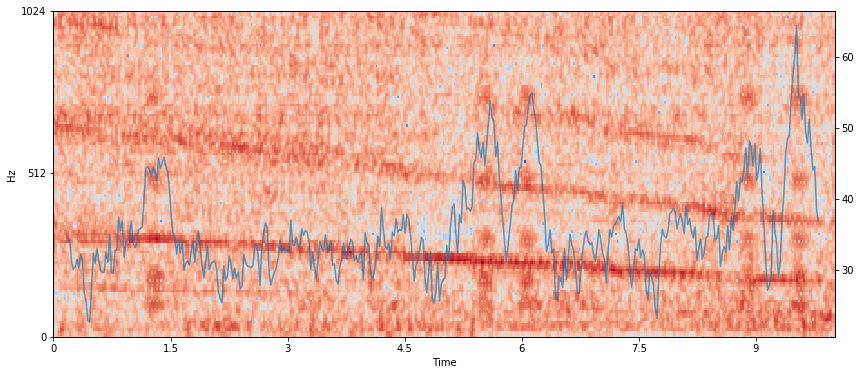

In [157]:
import librosa.display
x =[]
test_xt = librosa.power_to_db(librosa.feature.melspectrogram(test_piece, n_mels =128, fmax= 1024))
fig = plt.gcf()
fig.set_size_inches(14,6)
ax = plt.subplot()

ax2 = ax.twinx()
librosa.display.specshow(test_xt, fmax = 1024, y_axis = "mel", ax = ax, x_axis = 'time')
for i in range(len(score)):
    x.append((i+8)*(512/sr))
ax2.plot(x,score, alpha = 0.7)

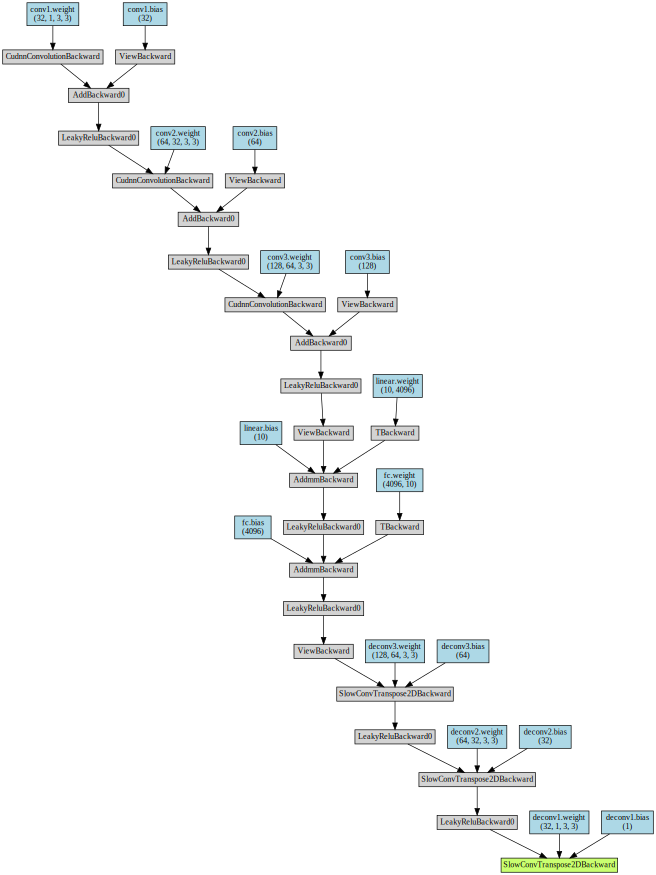

In [161]:
from torchviz import make_dot 
make_dot(recons, params = dict(autoencoder.named_parameters()))

In [163]:
from torch.utils.tensorboard import SummaryWriter 
writer = SummaryWriter("runs/ae_experiment_1")

In [169]:
writer.add_graph(autoencoder,images)
